# SchW-BERT-GAN ファインチューニング
- 事前学習済みのモデルを使用したSchW-BERT-GAN用のモジュールの定義
    - body選択
    - SchwBertGenerator
    - SchwBertDiscriminator
- SchW-BERT-GANのファインチューニングの実施
    - ファインチューニング用関数を作成
    - 事前学習済みのものと比較
- SchW-BERT-GANによる音楽自動生成
    - バンドルをデータセットからランダムに選んできて生成

WGAN-gpの実装は[eriklindernoren/PyTorch-GAN](https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py)が参考になる  
他にもいろいろPytorchのGANが実装されてる

In [1]:
import os, glob, copy, time, math
visible_devices = [2,3]
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(i) for i in visible_devices])

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.modules.normalization import LayerNorm
from torch.utils.data import random_split
from pytorch_memlab import MemReporter
from multiprocessing import Pool, cpu_count
from pypianoroll import Track, Multitrack
from attrdict import AttrDict
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# カレントディレクトリをリポジトリ直下にして自家製モジュールをimport
while os.getcwd().split('/')[-1] != 'schwbert': os.chdir('..')
print('current dir:', os.getcwd())
from utils import Timer, count_params, grad_status, grid_plot
from bundle import Bundle
from preprocess.original import load_bundle_list
from dataloader import TheorytabDataset, TheorytabDataLoader
from modules.model import gelu, save_body, load_body, make_body
from modules.multi_gpu import MultiGPUWrapper
from modules.save_and_load import save_config, load_config, save_model, load_model

core_num = 20
print(f"{core_num}/{cpu_count()} cpus are available.")

current dir: /root/schwbert
20/32 cpus are available.


In [2]:
base_dir = "../datasets"
schwbert_dir = os.path.join(base_dir, "schwbert")

dataset_dir = os.path.join(base_dir, "theorytab")
input_csv = os.path.join(dataset_dir, "theorytab.csv")
input_dir = os.path.join(dataset_dir, "pianoroll")

models_dir = os.path.join(schwbert_dir, "models", "theorytab")
pretrained_dir = os.path.join(models_dir, "pretrained")
finetuned_dir = os.path.join(models_dir, "finetuned")

for directory in [schwbert_dir, models_dir, pretrained_dir, finetuned_dir]:
    if not os.path.exists(directory):
        os.mkdir(directory)

### Configのロード

In [3]:
def select_config(directory, postfix=".json", fixed_number=None):
    config_paths = glob.glob(os.path.join(directory, f"*{postfix}"))
    config_paths.sort()
    if len(config_paths) > 1:
        print(f"{len(config_paths)} models found in {directory}")
        for i, path in enumerate(config_paths):
            print(f"{i}: {path.split('/')[-1]}")
        if fixed_number is None:
            config_path = config_paths[int(input("input the number of config:"))]
        else:
            config_path = config_paths[fixed_number]
    else:
        config_path = config_paths[0]
    
    config_name = config_path.split('/')[-1]
    print(f"config is loaded from {config_name}")
    config = load_config(config_name, directory)
    return AttrDict(config)

In [4]:
config = select_config(pretrained_dir, fixed_number=4)
config.nickname = "schwbertgan"
config.noise_size = 256
config.dtt = 2
config.gtt = 5
config.gp_lambda = 10
config.dropout_rate = 0.0
print(config)

5 models found in ../datasets/schwbert/models/theorytab/pretrained
0: schwbert_mnp:config@2019-11-24_07:41.json
1: schwbert_mnp:config@2019-11-24_08:38.json
2: schwbert_msp_mnp:config@2019-11-24_10:07.json
3: schwbert_no_share:config@2019-11-28_01:56.json
4: schwbert_no_shortcuts:config@2019-11-27_21:36.json
config is loaded from schwbert_no_shortcuts:config@2019-11-27_21:36.json
AttrDict({'nickname': 'schwbertgan', 'step_num': 768, 'beat_resolution': 12, 'beats_in_bar': 4, 'bar_num': 16, 'include_rest_to_area': False, 'melody_pitch_range': [0, 24], 'melody_rest_id': 24, 'melody_mask_id': 25, 'melody_pad_id': 26, 'melody_vocab_size': 27, 'chord_pad_id': 4096, 'chord_vocab_size': 4097, 'fact_size': 16, 'hidden_size': 256, 'intermediate_size': 1024, 'attention_layer_num': 3, 'attention_head_num': 8, 'share_all_bert_params': False, 'dropout_prob': 0.0, 'adam_lr': 1e-05, 'adam_beta1': 0.9, 'adam_beta2': 0.999, 'pre_mnp_aug': 2, 'pre_msp_aug': 3, 'pre_mnp_rate': 0.15, 'pre_mnp_mask_rate': 0

### データのロード

In [5]:
with Timer():
     bundle_list = load_bundle_list(input_csv, input_dir, core_num=core_num)

start preprocessing...
unpacking result bundles list...
Preprocessing Finished!
load 17396 bundles
0 error(s) occured
25.322407


Process ForkPoolWorker-19:
Process ForkPoolWorker-17:
Process ForkPoolWorker-20:
Process ForkPoolWorker-1:
Process ForkPoolWorker-14:
Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Process ForkPoolWorker-18:
Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-16:
Process ForkPoolWorker-4:
Process ForkPoolWorker-12:
Process ForkPoolWorker-13:
Process ForkPoolWorker-10:
Process ForkPoolWorker-11:
Process ForkPoolWorker-9:
Process ForkPoolWorker-6:
Process ForkPoolWorker-15:
Process ForkPoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (mos

In [6]:
dataset = TheorytabDataset(bundle_list)
dataloader = TheorytabDataLoader(dataset, batch_size=2, shuffle=True)
print(len(dataloader))

8698


# SchW-BERT-GAN用のモジュールの定義
- SchwBertGenerator*
    - NoiseEmbedding*
        - ノイズベクトルシーケンス→Dense
    - ConditionalBertBody
    - Denseをかけ，メロディを出力
- SchwBertDiscriminator*
    - ConditionalBertBody
    - Denseを縦横にかけ，本物と偽物を区別するよう2値分類

✳︎ついてるやつが新規作成モジュール

## 各種Embeddingsの実装
偽物のmax通したやつは誤差が伝搬しないのでベクトルシーケンスを入力に取りたい  
本物データにはOneHotになってもらう

In [7]:
class NoiseEmbedding(nn.Module):
    def __init__(self, config, noise_size, output_size, pad_id, include_rest=True):
        super(NoiseEmbedding, self).__init__()
        self.config = config
        self.noise_size = noise_size
        self.pad_id = pad_id
        self.include_rest = include_rest
        self.embedding = nn.Linear(noise_size, output_size, bias=False)
        self.norm = LayerNorm(output_size, eps=1e-12)
    
    def forward(self, input_ids, get_noise=False):
        # input_tesorはデバイス，サイズ，pad箇所の取得用(なのでchordを使う)
        device = input_ids.device
        batch_size, seq_len = input_ids.shape
        
        # ノイズを作成
        noise_vec_seq = torch.randn(batch_size, seq_len, self.noise_size)
        
        # PADのステップを0にする
        noise_vec_seq[input_ids == self.pad_id] = 0
        
        # ノイズの埋め込み表現を得る
        noise_vec_seq = noise_vec_seq.to(device)
        embedding = self.embedding(noise_vec_seq)
        embedding = self.norm(embedding)
        
        # PAD，Maskの音程を0にする．選択式で休符も0にする
        embedding[:, :, self.config.melody_pad_id] = 0
        embedding[:, :, self.config.melody_mask_id] = 0
        if not self.include_rest:
            embedding[:, self.config.melody_rest_id] = 0
        
        if get_noise:
            return embedding, noise_vec_seq
        else:
            return embedding

動作確認

In [8]:
batch = dataloader()
noise_embedding = NoiseEmbedding(config, config.noise_size, config.melody_vocab_size, config.chord_pad_id)
noise_emb = noise_embedding(batch.chord)

print("noise_embedding:", noise_emb.shape)
print(noise_emb[0][0])
print(noise_emb[0][-1])

noise_embedding: torch.Size([2, 768, 27])
tensor([ 0.7420,  1.5632, -0.2810, -0.2429,  2.7467, -0.8755, -0.2287, -0.7992,
        -0.6020, -1.7700,  0.7851, -0.4718,  1.0414, -0.0044,  0.9735, -0.4758,
        -1.8915,  0.0938,  0.2345, -0.0763,  1.0986, -0.0575,  0.5002,  0.4557,
        -0.4747,  0.0000,  0.0000], grad_fn=<SelectBackward>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], grad_fn=<SelectBackward>)


## SchWBertGeneratorの実装

In [8]:
class GELU(nn.Module):
    def forward(self, input_tensor):
        return gelu(input_tensor)

class Softmax(nn.Module):
    # なんかnn.Softmaxはinplace errorとかいうのが発生するので自前でSoftmaxを実装
    def __init__(self, dim):
        super(Softmax, self).__init__()
        self.dim = dim
    
    def forward(self, input_tensor):
        output = torch.exp(input_tensor)
        output = output / output.sum(dim=self.dim).unsqueeze(-1)
        return output

In [10]:
rand = torch.rand(3)
print(rand)
print(Softmax(dim=-1)(rand))
print(nn.Softmax(dim=-1)(rand))

tensor([0.5758, 0.2932, 0.5338])
tensor([0.3686, 0.2779, 0.3535])
tensor([0.3686, 0.2779, 0.3535])


In [9]:
class SchWBertGenerator(nn.Module):
    def __init__(self, config, body):
        super(SchWBertGenerator, self).__init__()
        self.config = config
        self.chord_pad_id = config.chord_pad_id
        self.melody_pad_id = config.melody_pad_id
         
        self.noise_embedding = NoiseEmbedding(config, config.noise_size, config.melody_vocab_size, self.chord_pad_id)
        self.body = body
        
        self.head = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            LayerNorm(config.hidden_size, eps=1e-8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(config.hidden_size, config.hidden_size),
            LayerNorm(config.hidden_size, eps=1e-8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(config.hidden_size, config.melody_vocab_size),
            LayerNorm(config.melody_vocab_size, eps=1e-8),
            nn.LeakyReLU(0.2, inplace=True),
            Softmax(dim=-1),
        )
    
    def forward(self, condition_tensor, get_all_outputs=False, get_probs=False):
        
        noise_emb = self.noise_embedding(condition_tensor)
        
        if get_probs:
            body_output, probs = self.body(noise_emb, condition_tensor, get_all_outputs, get_probs)
        else:
            body_output = self.body(noise_emb, condition_tensor, get_all_outputs, get_probs)
        
        if get_all_outputs:
            output = body_output[-1]
        else:
            output = body_output
        
        output = self.head(output)

        is_padded = (condition_tensor == self.chord_pad_id)
        ext_is_padded = torch.zeros_like(output, dtype=bool)
        ext_is_padded[:, :, self.melody_pad_id] = is_padded

        output[is_padded] *= 0.0
        output[ext_is_padded] += 1.0
                
        if get_all_outputs:
            output = body_output + output
        
        if get_probs:
            return output, probs
        else:
            return output
    
    def to_ids(self, output_map):
        probs, preds = torch.max(output_map, dim=-1)
        return preds

動作確認

In [11]:
batch = dataloader()

In [12]:
g_body = make_body(config)
G = SchWBertGenerator(config, g_body)
g_out = G(batch.chord)
print(g_out.shape)

torch.Size([2, 768, 27])


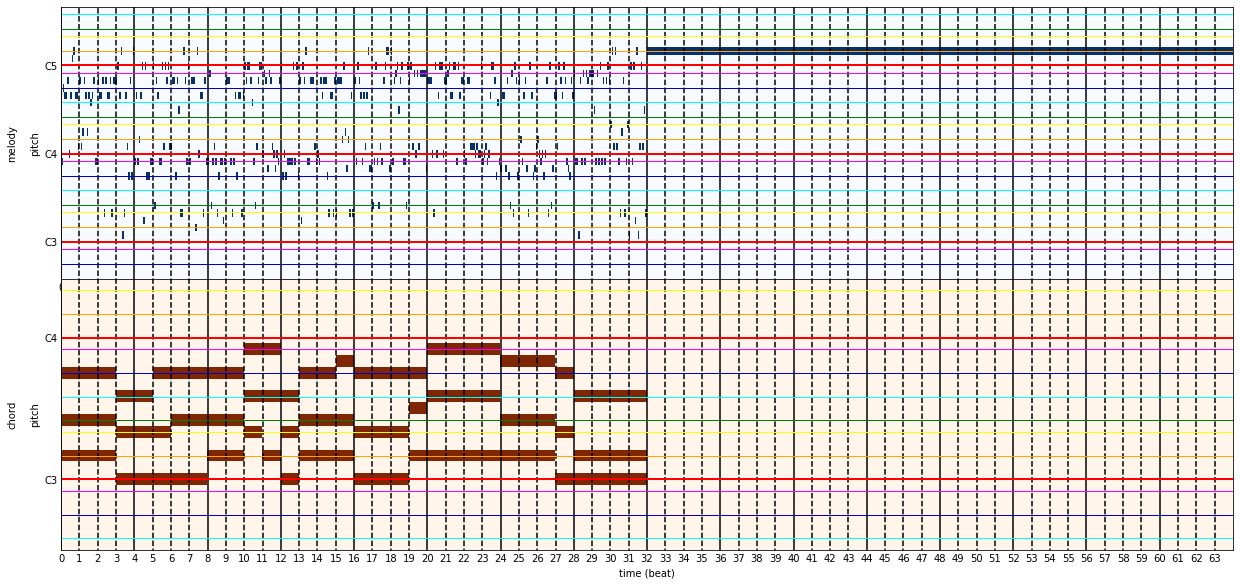

In [13]:
batch_id = 1

g_melody = G.to_ids(g_out).numpy()
bundle = Bundle({
    'melody': g_melody[batch_id],
    'chord': batch.chord[batch_id],
    'meta': batch.meta[batch_id]
})
bundle.meta.melody_pitch_range = [0, config.melody_vocab_size]
ppr = bundle.get_ppr()
grid_plot(ppr, beat_resolution=bundle.meta.beat_resolution)

## SchWBertDiscriminatorの実装

In [10]:
class SchWBertDiscriminator(nn.Module):
    def __init__(self, config, body):
        super(SchWBertDiscriminator, self).__init__()
        self.config = config
        self.body = body
        self.pad_id = config.chord_pad_id
        
        self.head_v = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            LayerNorm(config.hidden_size, eps=1e-8),
            GELU(),
            nn.Linear(config.hidden_size, config.hidden_size),
            LayerNorm(config.hidden_size, eps=1e-8),
            GELU(),
            nn.Linear(config.hidden_size, 1),
            GELU(),
        )
        
        self.dense_h = nn.Linear(config.step_num, 1)
        # self.sigmoid = nn.Sigmoid() # BCELossに含まれるのでSigmoidしない
    
    def forward_head(self, body_output):
        output = self.head_v(body_output)
        output = output.view(-1, self.config.step_num)
        output = self.dense_h(output)
        # output = self.sigmoid(output)
        return output.view(-1)
            
    def forward(self, input_tensor, condition_tensor, get_all_outputs=False, get_probs=False):
        if get_probs:
            body_output, probs = self.body(input_tensor, condition_tensor, get_all_outputs, get_probs)
        else:
            body_output = self.body(input_tensor, condition_tensor, get_all_outputs, get_probs)
        
        if get_all_outputs:
            output = body_output[-1]
        else:
            output = body_output

        output[condition_tensor == self.pad_id] *= 0
        output = self.forward_head(output)
        
        if get_all_outputs:
            output = body_output + output
        
        if get_probs:
            return output, probs
        else:
            return output

        
        
class SchWBertDiscriminatorLight(nn.Module):
    def __init__(self, config, body):
        super(SchWBertDiscriminatorLight, self).__init__()
        self.config = config
        self.pad_id = config.chord_pad_id
        self.to_one_hot = torch.eye(config.melody_vocab_size, dtype=torch.float)
        
        self.embeddings = body.embeddings
        
        self.head_1 = nn.Sequential(
            nn.Linear(config.hidden_size, 32),
            LayerNorm(32, eps=1e-8),
            GELU()
        )
        
        self.head_2 = nn.Sequential(
            nn.Linear(32 * config.step_num, 16),
            LayerNorm(16, eps=1e-8),
            GELU(),
            nn.Linear(16, 1)
        )
                    
    def forward_head(self, body_output):
        output = self.head_1(body_output)
        output = output.view(len(output), -1)
        output = self.head_2(output)
        return output.view(-1)
            
    def forward(self, input_tensor, condition_tensor):
        input_tensor = self.embeddings(input_tensor, condition_tensor)
        output = self.forward_head(input_tensor)
        return output

動作確認

In [16]:
d_body = make_body(config)
D = SchWBertDiscriminator(config, d_body)

batch = dataloader()
d_out_real = D(batch.melody, batch.chord)
d_out_fake = D(G(batch.chord), batch.chord)

print("real:", d_out_real)
print("fake:", d_out_fake)

real: tensor([-0.0723,  0.0174], grad_fn=<ViewBackward>)
fake: tensor([ 0.0758, -0.0358], grad_fn=<ViewBackward>)


In [17]:
d_body = make_body(config)
D = SchWBertDiscriminatorLight(config, d_body)

batch = dataloader()
d_out_real = D(batch.melody, batch.chord)
d_out_fake = D(G(batch.chord), batch.chord)

print("real:", d_out_real)
print("fake:", d_out_fake)

real: tensor([ 0.3241, -0.1354], grad_fn=<ViewBackward>)
fake: tensor([0.2228, 0.2244], grad_fn=<ViewBackward>)


# SchW-BERT-GANのファインチューニングの実施
事前学習済みのものとの比較もやる

### モデルの用意

In [11]:
device = torch.device('cuda')
init_g_body = False
init_d_body = True
multi_gpu = (len(visible_devices) > 1) & (device.type == 'cuda')

if init_g_body:
    print("Use initialized body in G")
    g_body = make_body(config)
else:
    print("Use pre-trained body in G")
    g_body = load_body(config, pretrained_dir)
G = SchWBertGenerator(config, g_body)


if init_d_body:
    print("Use initialized body in D")
    d_body = make_body(config)
else:
    print("Use pre-trained body in D")
    d_body = load_body(config, pretrained_dir)
D = SchWBertDiscriminatorLight(config, d_body)
# D = SchWBertDiscriminator(config, d_body)


G, D = G.to(device), D.to(device)


if multi_gpu:
    print("Use Multi GPUs")
    G, D = MultiGPUWrapper(G), MultiGPUWrapper(D)


g_optim = optim.Adam(G.parameters(), lr=1e-5, betas=(0.5, 0.999))
d_optim = optim.Adam(D.parameters(), lr=1e-5, betas=(0.5, 0.999))

print("Network settings completed")
print("#parameters of G:", count_params(G))
print("#parameters of D:", count_params(D))

Use pre-trained body in G
Use initialized body in D
Use Multi GPUs
Network settings completed
#parameters of G: 2618775
#parameters of D: 504497


### 学習用データの作成

In [12]:
batch_size = 75
# batch_size = 12
dataloader = TheorytabDataLoader(dataset, batch_size=batch_size, shuffle=True)
print("data num:", len(dataloader.dataset))
print("batch num:", len(dataloader))

data num: 17396
batch num: 232


## WGAN-gpによる訓練
参考：https://github.com/caogang/wgan-gp/blob/master/gan_mnist.py  
https://github.com/Zeleni9/pytorch-wgan/blob/master/models/wgan_gradient_penalty.py

In [13]:
to_one_hot = torch.eye(config.melody_vocab_size, dtype=torch.float)

def calculate_gradient_penalty(D, real, fake, chord, gp_lambda, device):
    
    # realの方はIDが渡ってくる，interpolates計算のため，one hot化
    real_one_hot = to_one_hot[real].to(device)
    
    # Random Weighted AverageによりRealとFakeの中間テンソルを取得
    eta = torch.empty(len(real), 1, 1).uniform_(0, 1).to(device)
    interpolates = eta * real_one_hot + ((1 - eta) * fake)
    interpolates = interpolates.requires_grad_(True)

    # 中間テンソルをDに通したテンソルを取得
    d_interpolates = D(interpolates, chord)

    # 勾配計算の終端へ与える値？を作成
    grad_outputs = torch.ones((len(real),)).to(device)
    grad_outputs.requires_grad = False
    
    # 勾配ペナルティの計算に使用する勾配を取得
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs, 
        create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(len(gradients), -1)

    # 勾配ペナルティの計算
    grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * gp_lambda
    
    return grad_penalty



def train_wgan_gp(G, D, g_optim, d_optim, gtt, dtt, adaptive, gp_lambda, dataloader, epoch_num, output_dir, device,
              start_epoch=1, report_period=50, clear_disp_epoch_period=3, save_epoch_period=None, get_status_dict=True):
    
    torch.backends.cudnn.benchmark = True
    
    batch_num = len(dataloader)
    batch_size = dataloader.batch_size
    
    current_dtt, current_gtt = dtt, gtt
    train_turn_table = np.zeros(dtt+gtt, dtype=bool)
    train_turn_table[:dtt] = True
    iteration = 0
    status_dict = { 'd_loss_real': [], 'd_loss_fake': [], 'wasserstein_d': [], 'g_loss': [] }
    
    G.train()
    D.train()

    try:
        total_d_loss_real = 0.0
        total_d_loss_fake = 0.0
        total_wasserstein_d = 0.0
        total_g_loss = 0.0
        
        for epoch in range(start_epoch, epoch_num+1):
            
            print(f"----- Epoch {epoch:>3} / {epoch_num:<3} start -----")
            t_epoch_start = time.time()
            t_iter_start = time.time()
            
            for batch_iteration, batch in enumerate(dataloader, 1):
                real, chord = batch.melody, batch.chord.to(device)
                
                # Turn tableを回す
                turn = iteration % (current_dtt+current_gtt)
                iteration += 1
                
                ############
                # DのTurn
                ############
                if train_turn_table[turn]:
                    D.zero_grad()
                    
                    real = real.to(device)
                                        
                    with torch.set_grad_enabled(True):
                        # realデータに対するLoss
                        d_loss_real = D(real, chord)
                        d_loss_real = d_loss_real.mean()
                        total_d_loss_real += d_loss_real.item()

                        # fakeデータに対するLoss
                        fake = G(chord)
                        d_loss_fake = D(fake, chord)
                        d_loss_fake = d_loss_fake.mean()
                        total_d_loss_fake += d_loss_fake.item()
                        
                        # 勾配ペナルティ
                        gradient_penalty = calculate_gradient_penalty(D, real, fake, chord, gp_lambda, device)

                        # DのLoss全体，および Wasserstein距離を獲得
                        d_loss = d_loss_fake - d_loss_real + gradient_penalty
                        wasserstein_d = d_loss_real - d_loss_fake
                        total_wasserstein_d += wasserstein_d.item()

                        # Dのパラメータを更新
                        d_loss.backward()
                        d_optim.step()
                    
                    if turn == current_dtt - 1:
                        # Turnの平均の記録
                        status_dict['d_loss_real'].append(total_d_loss_real / current_dtt)
                        status_dict['d_loss_fake'].append(total_d_loss_fake / current_dtt)
                        status_dict['wasserstein_d'].append(total_wasserstein_d / current_dtt)
                        total_d_loss_real = 0.0
                        total_d_loss_fake = 0.0
                        total_wasserstein_d = 0.0
                
                ############
                # GのTurn
                ############
                else:
                    G.zero_grad()

                    with torch.set_grad_enabled(True):
                        g_loss = D(G(chord), chord)
                        g_loss = - g_loss.mean()
                        
                        total_g_loss += g_loss.item()
                        
                        # Gのパラメータを更新
                        g_loss.backward()
                        g_optim.step()
                    
                    if turn == (current_gtt + current_dtt) - 1:
                        # Turnの平均の記録
                        status_dict['g_loss'].append(total_g_loss / current_gtt)
                        total_g_loss = 0.0
                
                
                #############################
                # Adaptive WGAN-gp
                # WDに応じてturn_tableを更新
                #############################
                if adaptive and len(status_dict['wasserstein_d']) > 0:
                    last_wd = status_dict['wasserstein_d'][-1]
                    current_dtt = int(dtt * max(1 - last_wd, 1))
                    current_gtt = int(gtt * max(1 + last_wd, 1))
                    train_turn_table = np.zeros(current_dtt + current_gtt, dtype=bool)
                    train_turn_table[:current_dtt] = True

                
                ####################
                # IterationのReport
                ####################
                if (iteration % report_period == 0):
                    duration = time.time() - t_iter_start
                    print(f"Iteration {batch_iteration:>4}/{batch_num:<4} | D real: {d_loss_real:.5f} | D fake: {d_loss_fake:.5f} | WD: {wasserstein_d:.5} | G loss: {g_loss:.5f} | dtt: {current_dtt} | gtt: {current_gtt} | {duration:.4f} [sec]")
                    t_iter_start = time.time()



            ################
            # EpochのReport
            ################
            
            epoch_duration = time.time() - t_epoch_start
            print(f"Epoch {epoch:>3} / {epoch_num:<3} finished in {epoch_duration:.4f}[sec]")
            
            last_d_loss_real = status_dict['d_loss_real'][-1]
            last_d_loss_fake = status_dict['d_loss_fake'][-1]
            last_wasserstein_d = status_dict['wasserstein_d'][-1]
            last_g_loss = status_dict['g_loss'][-1]
            print(f"Epoch {epoch:>3} / {epoch_num:<3} Last Scores | D real: {last_d_loss_real:.6f} | D fake: {last_d_loss_fake:.6f} | WD: {last_wasserstein_d:.6f} | G loss: {last_g_loss:.6f}")
            
            remain_sec = epoch_duration * (epoch_num - epoch)
            print(f"Remaining Time | {remain_sec/3600:.4f} [hour] | {remain_sec/60:.2f} [min] | {remain_sec:.0f} [sec]\n")
            
            if epoch % clear_disp_epoch_period == 0:
                clear_output()
            
            # チェックポイントモデルの保存
            if (save_epoch_period is not None) and (epoch % save_epoch_period == 0):
                print("start saving models")
                save_model(config, G, epoch, output_dir)
                save_model(config, D, epoch, output_dir)
                print("")

        print("All Fine-Tuning Finished!")
        
    except KeyboardInterrupt:
        print("Keyboard interrupted, but return models.")
        if get_status_dict:
            return G, D, status_dict
        return G, D
    
    if get_status_dict:
        return G, D, status_dict
    return G, D

訓練の実行

In [15]:
epoch_num = 200
G_trained, D_trained, status_dict = train_wgan_gp(
    G=G, D=D,
    g_optim=g_optim, d_optim=d_optim,
    gtt=config.gtt, dtt=config.dtt,
    adaptive=True, 
    gp_lambda=config.gp_lambda,
    dataloader=dataloader,
    epoch_num=epoch_num,
    output_dir=finetuned_dir,
    device=device,
    start_epoch=1,
    report_period=len(dataloader) // 3
)

----- Epoch 199 / 200 start -----
Iteration   36/232  | D real: 1.03892 | D fake: 1.26393 | WD: -0.22501 | G loss: -1.29751 | dtt: 2 | gtt: 5 | 16.1726 [sec]
Iteration  113/232  | D real: 1.20837 | D fake: -1.24150 | WD: 2.4499 | G loss: 1.29752 | dtt: 2 | gtt: 16 | 34.6325 [sec]
Iteration  190/232  | D real: 1.42999 | D fake: -1.83108 | WD: 3.2611 | G loss: 1.82867 | dtt: 2 | gtt: 20 | 34.2260 [sec]
Epoch 199 / 200 finished in 103.3128[sec]
Epoch 199 / 200 Last Scores | D real: 1.313076 | D fake: -2.009903 | WD: 3.322979 | G loss: 1.874292
Remaining Time | 0.0287 [hour] | 1.72 [min] | 103 [sec]

----- Epoch 200 / 200 start -----
Iteration   35/232  | D real: 1.20173 | D fake: -1.88259 | WD: 3.0843 | G loss: 1.87004 | dtt: 2 | gtt: 20 | 15.4143 [sec]
Iteration  112/232  | D real: 1.36251 | D fake: -1.97461 | WD: 3.3371 | G loss: 1.93677 | dtt: 2 | gtt: 21 | 33.5175 [sec]
Iteration  189/232  | D real: 1.29768 | D fake: -2.09658 | WD: 3.3943 | G loss: 2.11391 | dtt: 2 | gtt: 22 | 33.9821

Statusグラフの表示

In [16]:
def show_status_graph_wgan_gp(status_dict, title="Score graphs of WGAN-gp"):
    d_loss_real = status_dict['d_loss_real']
    d_loss_fake = status_dict['d_loss_fake']
    wasserstein_d = status_dict['wasserstein_d']
    g_loss = status_dict['g_loss']
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    
    x = np.arange(len(d_loss_real))
    axs[0].plot(x, d_loss_real, label='real', linewidth=1.5)
    axs[0].plot(x, d_loss_fake, label='fake', linewidth=1.5)
    axs[0].legend(loc='upper right')
    axs[0].set_xlabel('turn')
    axs[0].set_ylabel('loss')
    axs[0].set_title(f"D losses")

    axs[1].plot(x, wasserstein_d, label='wasserstein_d', linewidth=1.5)
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel('turn')
    axs[1].set_ylabel('wasserstein_d')
    axs[1].set_title(f"Wasserstein distance")
    
    x = np.arange(len(g_loss))
    axs[2].plot(x, g_loss, label='loss', linewidth=1.5)
    axs[2].legend(loc='upper right')
    axs[2].set_xlabel('turn')
    axs[2].set_ylabel('loss')
    axs[2].set_title(f"G loss")

    plt.show()

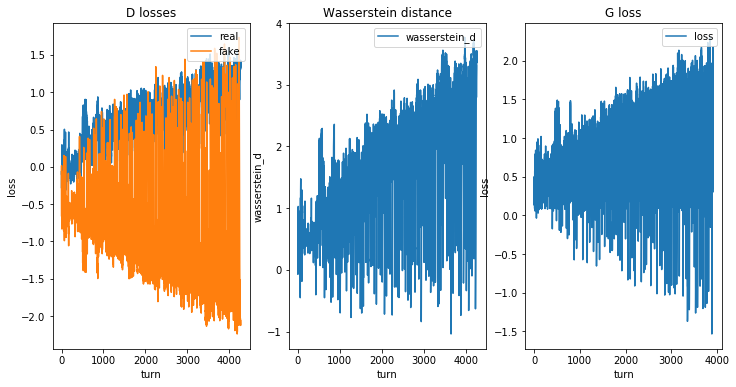

In [17]:
show_status_graph_wgan_gp(status_dict)

記念すべき初回実行  
とりあえず学習済みのbase  
ロクなものではない  
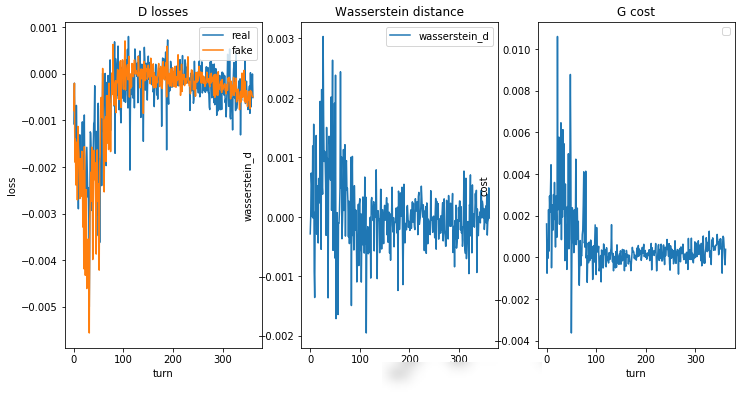

学習しないでやってみた場合  
WDがほぼ0だったりマイナスになったり，謎現象発生中  
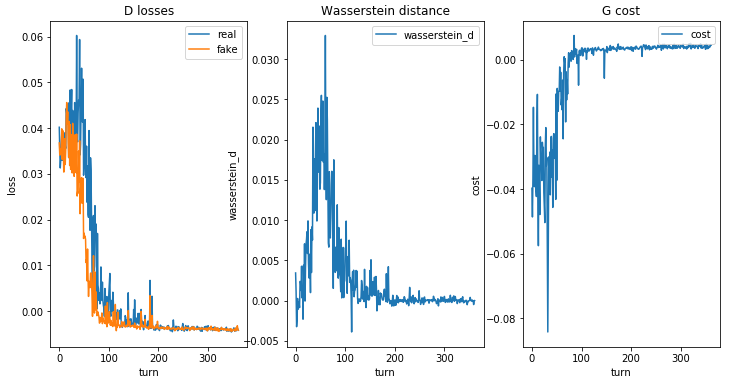

プログラム直してみたらWDの値とかが良い感じになった．  
しかしD強め？みたいなのでgtt3くらいにしてみるか？  
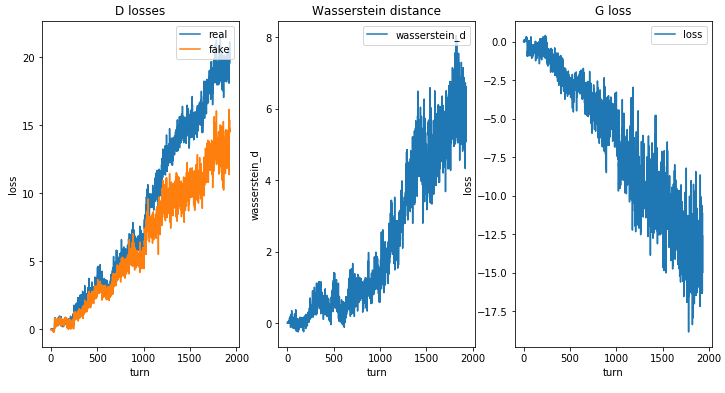

さらにMNP＋MSPの事前学習済みモデルをそのまま使えるようにしたバージョン  
全然Convergeしない．．．  
チューニング実験しながら論文読むか．．．  
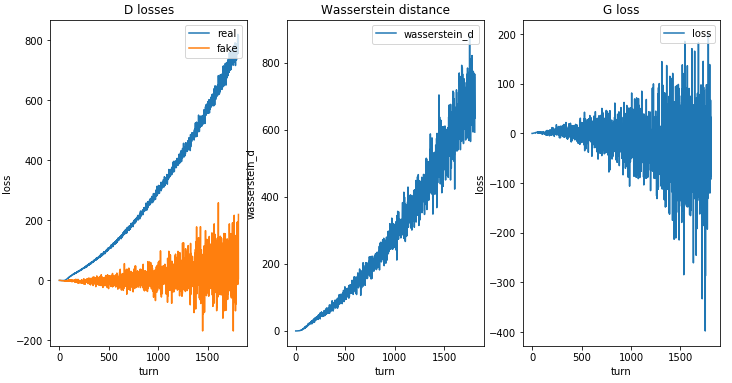

100エポックの出力結果消えた．．．でもまぁこんな感じ  
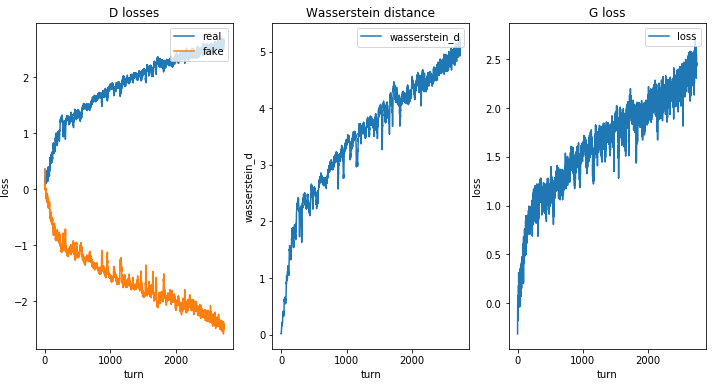

dtt:gtt = 2:5  
ほとんどが音程番号12になるというモード崩壊？が発生  
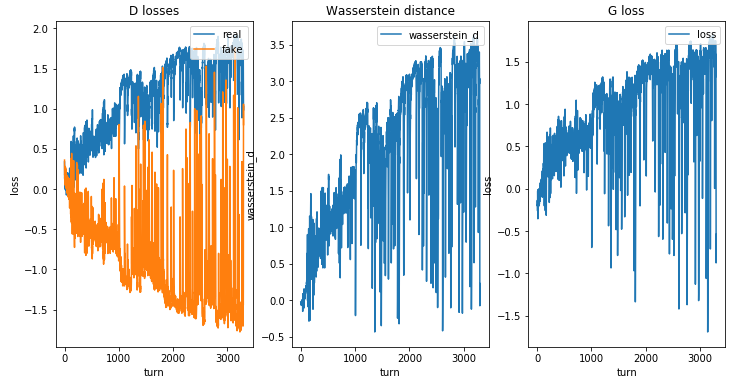

2:5の線形Adaptiveで200epoch  
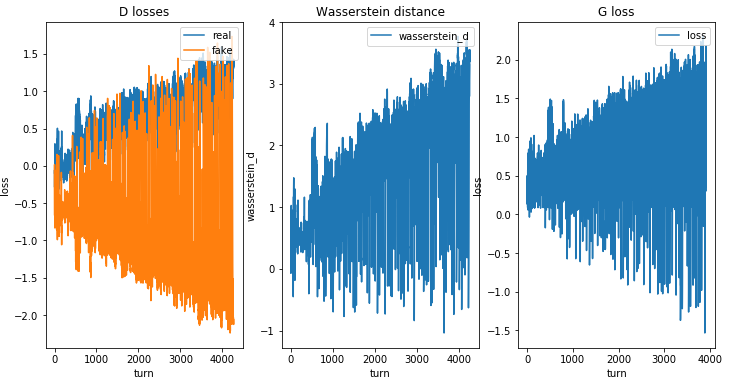

生成データの確認

In [25]:
batch = dataloader()
g_out = G_trained(batch.chord.to(device))
g_melody = G.to_ids(g_out).cpu().numpy()

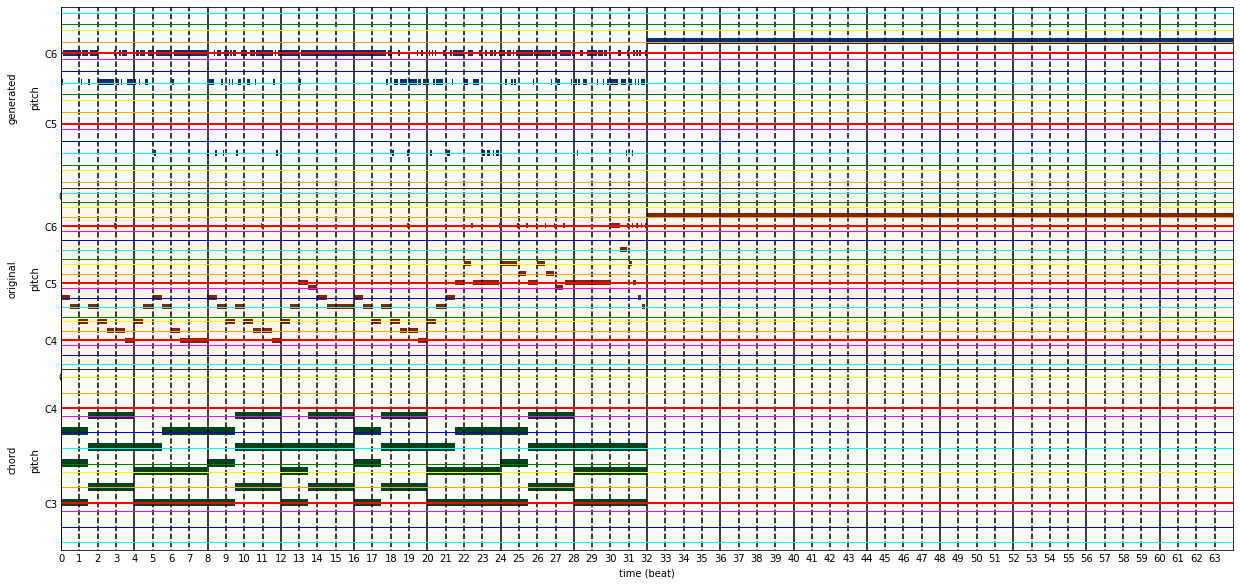

In [26]:
batch_id = 0

bundle = Bundle({
    'melody': g_melody[batch_id],
    'chord': batch.chord[batch_id],
    'meta': batch.meta[batch_id]
})
bundle.meta.melody_pitch_range = [0, config.melody_vocab_size]
ppr = bundle.get_ppr()

org_bundle = Bundle({
    'melody': batch.melody[batch_id],
    'chord': batch.chord[batch_id],
    'meta': batch.meta[batch_id]
})
org_bundle.meta.melody_pitch_range = [0, config.melody_vocab_size]
org_ppr = org_bundle.get_ppr()
ppr.tracks.insert(1, org_ppr.tracks[0])

ppr.tracks[0].name = "generated"
ppr.tracks[1].name = "original"
grid_plot(ppr, beat_resolution=bundle.meta.beat_resolution)

初回実行ではこんな感じか…  
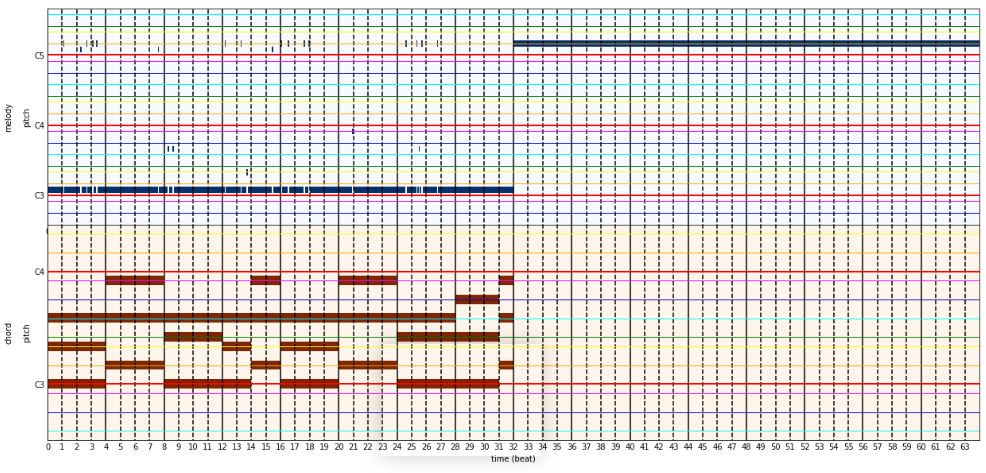

まぁ学習あったほうがバラバラにはならないみたいね  
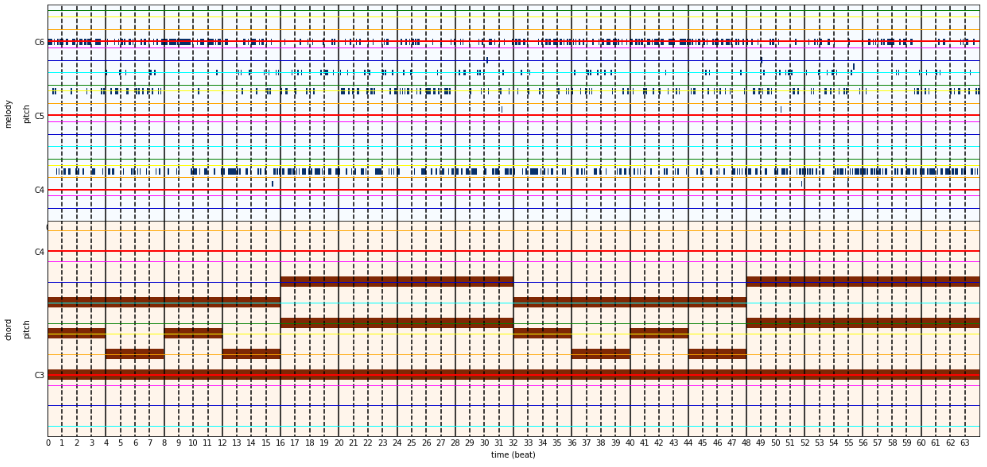

MNP+MSPで100エポック回してみた結果  
WDは全然収束してないけど，繰り返しは捉えられている  
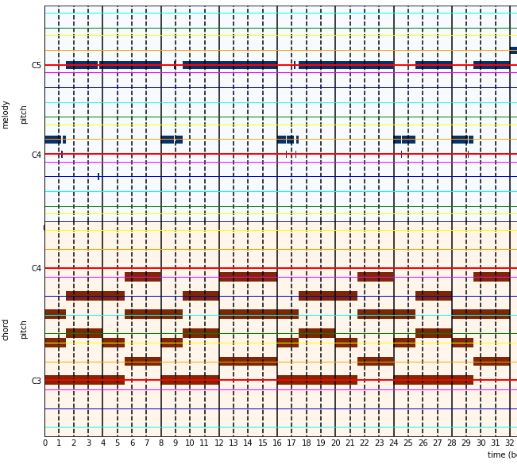

PADDINGがちゃんとなってない  
どっかにバグがあるはず  
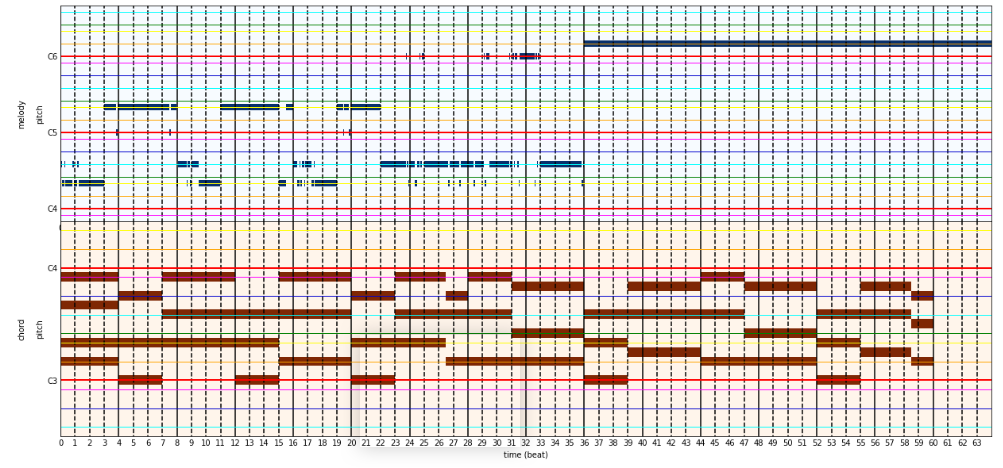

これもPADDINGちゃんとなってない，  
しかし，長期にわたる繰り返しを捉えられていることが分かる  
a/aretha-franklin/i-say-a-little-prayer/chorus_key.mid
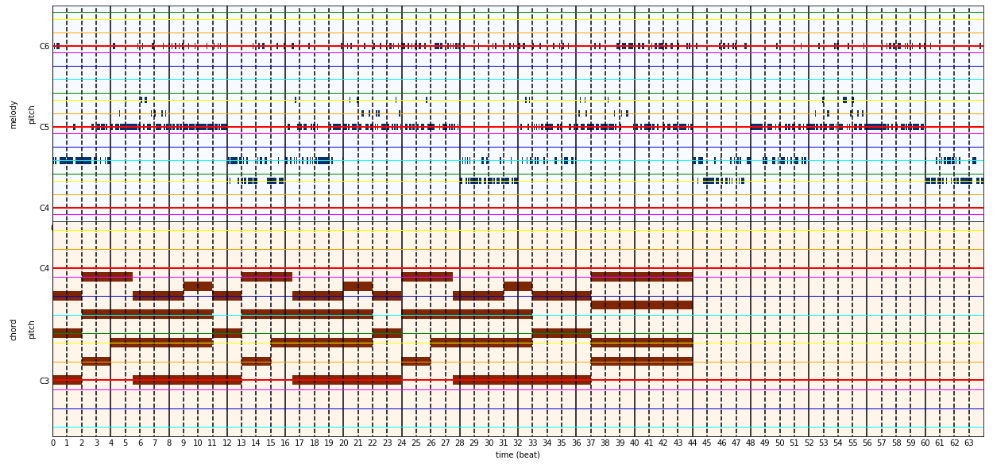

g/ginuwine/pony/chorus_key.midの生成結果  
繰り返しは捉えられていても，もしかしてコードの前処理が上手くいってない？  
いや，コードの前処理はうまくいってる．  
モデル内でのPADDINGの扱いが上手くいってない説  
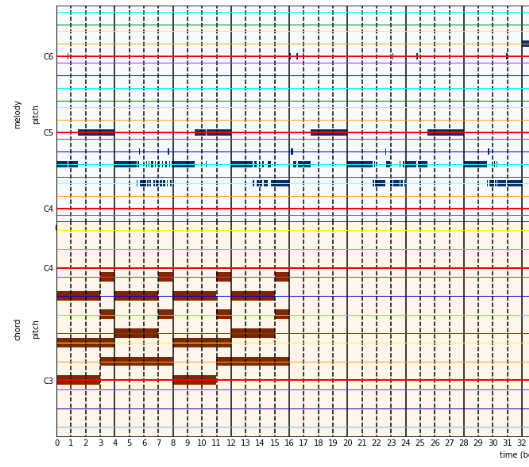

## ファインチューニング済みモデルの保存と読込み

In [20]:
state_names_dict = {
    'G': save_model(config, G_trained, epoch_num, finetuned_dir),
    'D': save_model(config, D_trained, epoch_num, finetuned_dir)
}
config_file_name = save_config(config, finetuned_dir, state_names_dict=state_names_dict)

schwbertgan:SchWBertGenerator:E=200H=256I=1024A=3AH=8.pth saved
schwbertgan:SchWBertDiscriminatorLight:E=200H=256I=1024A=3AH=8.pth saved
schwbertgan:config@2019-11-28_12:32.json saved


読込みはココから

In [21]:
config = select_config(finetuned_dir, fixed_number=None)

2 models found in ../datasets/schwbert/models/theorytab/finetuned
0: schwbert_no_shortcuts:config@2019-11-28_06:08.json
1: schwbertgan:config@2019-11-28_12:32.json
input the number of config:1
config is loaded from schwbertgan:config@2019-11-28_12:32.json


In [22]:
dataset = TheorytabDataset(bundle_list)
dataloader = TheorytabDataLoader(dataset, batch_size=2, shuffle=True)
print(len(dataloader))

8698


In [23]:
def load_gan(config, directory, device=None, multi_gpu=False, d_is_light=False):
    if device is None:
        device = torch.device('cpu')
    
    G = SchWBertGenerator(config, make_body(config))
    if d_is_light:
        D = SchWBertDiscriminatorLight(config, make_body(config))
    else:
        D = SchWBertDiscriminator(config, make_body(config))
    G_trained = load_model(G, config.state_names.G, directory).to(device)
    D_trained = load_model(D, config.state_names.D, directory).to(device)
    
    if multi_gpu:
        G_trained, D_trained = MultiGPUWrapper(G_trained), MultiGPUWrapper(D_trained)
        
    return G_trained, D_trained

In [24]:
device = torch.device('cuda')
G_trained, D_trained = load_gan(config, finetuned_dir, device=device, d_is_light=True)

生成実験は上に行ってね

### Adaptive WGAN-gpの学習回数グラフ

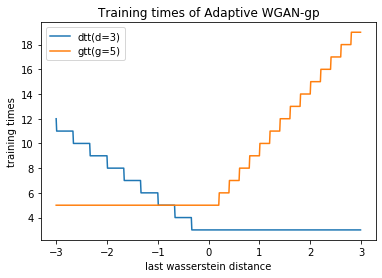

In [18]:
dtt, gtt = 3, 5
last_wds = np.arange(-3, 3, 0.01)
dtts = dtt * np.clip(1 - last_wds, 1, None)
gtts = gtt * np.clip(1 + last_wds, 1, None)
dtts, gtts = dtts.astype(int), gtts.astype(int)

plt.plot(last_wds, dtts, label=f"dtt(d={dtt})")
plt.plot(last_wds, gtts, label=f"gtt(g={gtt})")
plt.title("Training times of Adaptive WGAN-gp")
plt.xlabel("last wasserstein distance")
plt.ylabel("training times")
plt.legend()
plt.show()

## 考察

Adaptiveしてもビクともしない感じ  
ひょっとしてBERTは大域的な情報を考慮できても局所的な情報に弱い？  
BERTは遠くの情報を考慮できる一方，近くにあるものと遠くにあるものを同様に扱いがちなのかもしれない  
しかし大域的な情報は利用したい．  
そこで，MidiNetのようなCNNベースのモデルにBERTを織り込むことを考える  
局所的な畳み込みを行いつつ，畳み込みの各段階でBERTを通して大域的な情報を考慮させる  